In [10]:
# ==== LOAD CHECKPOINT ====
import pandas as pd, numpy as np, json
from pathlib import Path

# Đổi đường dẫn này theo log của mày
BASE_DIR = Path(r"C:\Users\ADMIN\Documents\Khóa luận\MovieTweetings Dataset\data\processed\20251102-161934")

data  = pd.read_parquet(BASE_DIR / "data_clean.parquet")
folds = {
    "Fold_1": {
        "train": pd.read_parquet(BASE_DIR / "fold1_train.parquet"),
        "test":  pd.read_parquet(BASE_DIR / "fold1_test.parquet")
    },
    "Fold_2": {
        "train": pd.read_parquet(BASE_DIR / "fold2_train.parquet"),
        "test":  pd.read_parquet(BASE_DIR / "fold2_test.parquet")
    },
    "Fold_3": {
        "train": pd.read_parquet(BASE_DIR / "fold3_train.parquet"),
        "test":  pd.read_parquet(BASE_DIR / "fold3_test.parquet")
    },
}
meta = json.load(open(BASE_DIR / "meta.json", encoding="utf-8")) #Mở file meta.json (file chứa thông tin cấu hình của checkpoint)
print("Loaded.", meta["version"], "| ratings:", len(data))

Loaded. 20251102-161934 | ratings: 919019


In [11]:
print("Shape:", data.shape)
print("Columns:", list(data.columns))
print("Head:")
print(data.head(5))

Shape: (919019, 9)
Columns: ['UserID', 'MovieID', 'Rating', 'Timestamp', 'Datetime', 'Title', 'Genres', 'GenresList', 'YearFromTitle']
Head:
   UserID   MovieID  Rating   Timestamp            Datetime  \
0       1    114508       8  1381006850 2013-10-05 21:00:50   
1       2   1428538       1  1371307089 2013-06-15 14:38:09   
2       2   1305591       8  1376742507 2013-08-17 12:28:27   
3       2    499549       9  1376753198 2013-08-17 15:26:38   
4       3  10039344       5  1578603053 2020-01-09 20:50:53   

                                      Title  \
0                            Species (1995)   
1  Hansel Amp; Gretel: Witch Hunters (2013)   
2                    Mars Needs Moms (2011)   
3                             Avatar (2009)   
4                          Countdown (2019)   

                              Genres                              GenresList  \
0      Action|Horror|Sci-Fi|Thriller      [Action, Horror, Sci-Fi, Thriller]   
1              Action|Fantasy|Horror 

In [12]:
# ================== CONTENT-BASED (TF-IDF) for MovieTweetings ==================
import numpy as np, pandas as pd
from datetime import datetime
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from scipy import sparse

In [13]:
# ---------------------- A. Item profiles ----------------------
def build_item_text(df):
    """
    Ghép text cho mỗi phim từ Title + Genres (+ YearFromTitle nếu có).
    Trả: DataFrame [MovieID, text] (mỗi MovieID 1 dòng).
    """
    assert 'MovieID' in df.columns, "Thiếu cột MovieID."
    def row_to_text(r):
        title  = str(r.get('Title', '') or '')
        genres = str(r.get('Genres','') or '').replace('|', ' ')
        year   = ''
        if 'YearFromTitle' in df.columns and pd.notna(r.get('YearFromTitle', np.nan)):
            try: year = f"year{int(r['YearFromTitle'])}"
            except: pass
        return " ".join([title, genres, year]).strip()

    cols = [c for c in ['MovieID','Title','Genres','YearFromTitle'] if c in df.columns]
    items = df[cols].drop_duplicates('MovieID').copy()
    items['text'] = items.apply(row_to_text, axis=1)
    return items[['MovieID','text']]

def fit_item_vectorizer(items_df):
    """
    TF-IDF + L2 normalize để cosine similarity = dot product.
    """
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        lowercase=True,
        analyzer='word',
        ngram_range=(1,2),
        min_df=2, max_df=0.6
    )
    X = vectorizer.fit_transform(items_df['text'])
    X = normalize(X)  # L2
    movie_ids = items_df['MovieID'].to_numpy()
    id2row = {m:i for i,m in enumerate(movie_ids)}
    return vectorizer, X, movie_ids, id2row

In [14]:
# ---------------------- B. User profiles ----------------------
USE_TIME_DECAY = True
DECAY_HALF_LIFE_DAYS = 180  # bán rã 180 ngày

def compute_user_profiles(train_df, X_items, id2row, pos_thresh=7, now_ts=None):
    """
    Tạo vector hồ sơ user từ train (rating >= pos_thresh).
    Trọng số = (rating - pos_thresh) * time_decay (nếu bật).
    """
    ucol, icol, rcol, tcol = 'UserID','MovieID','Rating','Timestamp'
    for c in [ucol, icol, rcol]:
        assert c in train_df.columns, f"Thiếu cột {c} trong train."

    if USE_TIME_DECAY and (tcol in train_df.columns) and now_ts is None:
        now_ts = pd.to_datetime(train_df[tcol], unit='s', errors='coerce').max()

    if tcol in train_df.columns:
        tseries = pd.to_datetime(train_df[tcol], unit='s', errors='coerce')
    else:
        tseries = pd.Series(pd.NaT, index=train_df.index)

    by_user = defaultdict(list)  # uid -> [(row_idx_item, weight)]
    for (_, row), t in zip(train_df.iterrows(), tseries):
        mid = row[icol]
        if mid not in id2row: 
            continue
        w = max(0.0, float(row[rcol]) - pos_thresh)
        if w <= 0: 
            continue
        if USE_TIME_DECAY and pd.notna(t) and pd.notna(now_ts):
            delta_days = max(0.0, (pd.Timestamp(now_ts) - pd.Timestamp(t)).days)
            w *= 0.5 ** (delta_days / DECAY_HALF_LIFE_DAYS)
        if w > 0:
            by_user[row[ucol]].append((id2row[mid], w))

    user_profiles = {}
    for uid, pairs in by_user.items():
        rows, weights = zip(*pairs)
        mat = X_items[list(rows), :]             # [n_pos, d] sparse
        w   = np.asarray(weights).reshape(-1,1)  # [n_pos, 1]
        prof = (mat.multiply(w)).sum(axis=0)     # 1 x d (still sparse matrix)
        prof = sparse.csr_matrix(prof)
        prof = normalize(prof)                   # L2
        user_profiles[uid] = prof
    return user_profiles

User profiles – dựng hồ sơ người dùng từ lịch sử train
Ý tưởng

Lấy các phim user thích (rating ≥ pos_thresh).

Cộng có trọng số các vector phim đó để ra 1 vector “gu” của user.

Trọng số:

cơ bản: rating - pos_thresh (rating cao hơn ngưỡng thì đóng góp mạnh hơn),

tuỳ chọn time decay: càng cũ càng giảm trọng số (bám khẩu vị gần đây).

In [15]:
# ---------------------- C. Scoring & recommendation ----------------------
def build_seen_train(train_df):
    """ user -> set(MovieID) đã xem trong train (để lọc khỏi gợi ý) """
    return train_df.groupby('UserID')['MovieID'].apply(lambda s: set(s.values)).to_dict()

def recommend_for_users(user_profiles, X_items, movie_ids, seen_train, K=100):
    """
    Cosine similarity = uvec @ X_items.T (đã L2 normalize).
    QUAN TRỌNG: dùng .toarray() (KHÔNG dùng .A).
    """
    Xt = X_items.T  # [d, n_items] sparse
    recs = {}
    for uid, uvec in user_profiles.items():
        if uvec.nnz == 0:
            recs[uid] = []
            continue
        scores = (uvec @ Xt).toarray().ravel()     # <-- FIXED: .toarray()
        if uid in seen_train:
            mask_seen = np.fromiter((m in seen_train[uid] for m in movie_ids), dtype=bool, count=movie_ids.size)
            scores[mask_seen] = -1e9
        K_eff = min(K, scores.size)
        top = np.argpartition(scores, -K_eff)[-K_eff:]
        top = top[np.argsort(scores[top])[::-1]]
        recs[uid] = list(zip(movie_ids[top], scores[top]))
    return recs

In [16]:
# ---------------------- D. Metrics (ranking) ----------------------
def precision_recall_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid, _ in y_pred_ranked[:k]]
    hit  = sum(1 for iid in topk if iid in y_true_set)
    return hit / max(1, len(topk)), hit / max(1, len(y_true_set))

def hitrate_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid, _ in y_pred_ranked[:k]]
    return 1.0 if any(i in y_true_set for i in topk) else 0.0

def average_precision_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid, _ in y_pred_ranked[:k]]
    hits = ap = 0.0
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            hits += 1
            ap += hits / i
    return ap / max(1, min(len(y_true_set), k))

def dcg_at_k(rel, k):
    # FIX: np.asfarray -> np.asarray(..., dtype=float)
    rel = np.asarray(rel, dtype=float)[:k]
    if rel.size == 0:
        return 0.0
    return float(np.sum((2.0**rel - 1.0) / np.log2(np.arange(2, rel.size + 2))))

def ndcg_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid, _ in y_pred_ranked[:k]]
    rel = [1.0 if iid in y_true_set else 0.0 for iid in topk]
    dcg  = dcg_at_k(rel, k)
    idcg = dcg_at_k(sorted(rel, reverse=True), k)
    return (dcg / idcg) if idcg > 0 else 0.0

def mrr_at_k(y_true_set, y_pred_ranked, k=20):
    topk = [iid for iid, _ in y_pred_ranked[:k]]
    for i, iid in enumerate(topk, 1):
        if iid in y_true_set:
            return 1.0 / i
    return 0.0

def evaluate_fold(train_df, test_df, X_items, movie_ids, id2row, Ks=(10,20,50), pos_thresh=7):
    """
    Đánh giá 1 fold: build profile từ train, recommend, so sánh với test.
    """
    now_ts = pd.to_datetime(train_df['Timestamp'], unit='s', errors='coerce').max() if 'Timestamp' in train_df.columns else None
    user_profiles = compute_user_profiles(train_df, X_items, id2row, pos_thresh=pos_thresh, now_ts=now_ts)
    seen_train    = build_seen_train(train_df)
    recs_by_user  = recommend_for_users(user_profiles, X_items, movie_ids, seen_train, K=max(Ks))

    pos_test = (test_df[test_df['Rating'] >= pos_thresh]
                .groupby('UserID')['MovieID'].apply(set).to_dict())
    users_eval = [u for u in recs_by_user if u in pos_test and len(pos_test[u]) > 0]
    if not users_eval:
        return {"users_eval": 0, "pos_thresh": pos_thresh}

    out = {"users_eval": len(users_eval), "pos_thresh": pos_thresh}
    for K in Ks:
        HR=P=R=MAP=NDCG=MRR=0.0
        for u in users_eval:
            ranked = recs_by_user[u]
            truth  = pos_test[u]
            pk, rk = precision_recall_at_k(truth, ranked, k=K)
            HR    += hitrate_at_k(truth, ranked, k=K)
            P     += pk;  R += rk
            MAP   += average_precision_at_k(truth, ranked, k=K)
            NDCG  += ndcg_at_k(truth, ranked, k=K)
            MRR   += mrr_at_k(truth, ranked, k=K)
        n = len(users_eval)
        out.update({
            f'hit@{K}':       float(HR/n),
            f'precision@{K}': float(P/n),
            f'recall@{K}':    float(R/n),
            f'map@{K}':       float(MAP/n),
            f'ndcg@{K}':      float(NDCG/n),
            f'mrr@{K}':       float(MRR/n),
        })
    return out

In [17]:
# ---------------------- E. Runner: build once, evaluate all folds ----------------------
_items = build_item_text(data)
_vectorizer, X_items, movie_ids, id2row = fit_item_vectorizer(_items)

POS_LIST = (7, 8)          # có thể đổi: (6,7,8)
KS       = (10, 20, 50)

all_results = []
print("=== RUN Content-Based Evaluation ===")
for fold_name in sorted(folds.keys()):
    splits = folds[fold_name]
    train_df, test_df = splits['train'], splits['test']
    print(f"\n[Fold] {fold_name}: train={len(train_df):,} | test={len(test_df):,}")

    for POS in POS_LIST:
        try:
            metrics = evaluate_fold(train_df, test_df, X_items, movie_ids, id2row, Ks=KS, pos_thresh=POS)
        except Exception as e:
            print(f"  POS >= {POS} | ERROR: {type(e).__name__}: {e}")
            continue

        metrics['fold'] = fold_name
        metrics['pos_thresh'] = POS
        all_results.append(metrics)

        users_eval = metrics.get('users_eval', 0)
        present_keys = sorted(k for k in metrics if '@' in k)
        brief = {k: round(metrics[k], 4) for k in present_keys}
        print(f"  POS >= {POS} | users_eval={users_eval} | {brief}")

cb_results_df = pd.DataFrame(all_results)
print("\n=== Raw results (per fold & threshold) ===")
if not cb_results_df.empty:
    print(cb_results_df.fillna(0).head(10))
else:
    print("[WARN] Không có kết quả nào được ghi nhận.")

if not cb_results_df.empty:
    metric_cols = [c for c in cb_results_df.columns if any(c.startswith(m) for m in ['hit@','precision@','recall@','map@','ndcg@','mrr@'])]
    if metric_cols:
        summary = (cb_results_df.groupby('pos_thresh')[metric_cols].mean().round(4).sort_index())
        print("\n=== Tổng hợp (mean theo pos_thresh, qua các fold) ===")
        print(summary)
    else:
        print("\n[WARN] Không tìm thấy cột metric nào trong kết quả.")

=== RUN Content-Based Evaluation ===

[Fold] Fold_1: train=655,319 | test=263,700
  POS >= 7 | users_eval=22714 | {'hit@10': 0.0345, 'hit@20': 0.0551, 'hit@50': 0.0991, 'map@10': 0.0035, 'map@20': 0.0036, 'map@50': 0.0039, 'mrr@10': 0.0123, 'mrr@20': 0.0137, 'mrr@50': 0.015, 'ndcg@10': 0.0174, 'ndcg@20': 0.0225, 'ndcg@50': 0.0311, 'precision@10': 0.0039, 'precision@20': 0.0033, 'precision@50': 0.0025, 'recall@10': 0.0081, 'recall@20': 0.013, 'recall@50': 0.0228}
  POS >= 8 | users_eval=19132 | {'hit@10': 0.0251, 'hit@20': 0.0417, 'hit@50': 0.0756, 'map@10': 0.003, 'map@20': 0.0032, 'map@50': 0.0035, 'mrr@10': 0.0095, 'mrr@20': 0.0106, 'mrr@50': 0.0116, 'ndcg@10': 0.0131, 'ndcg@20': 0.0171, 'ndcg@50': 0.0238, 'precision@10': 0.0028, 'precision@20': 0.0024, 'precision@50': 0.0018, 'recall@10': 0.0067, 'recall@20': 0.0115, 'recall@50': 0.0198}

[Fold] Fold_2: train=698,450 | test=220,569
  POS >= 7 | users_eval=22629 | {'hit@10': 0.0318, 'hit@20': 0.0508, 'hit@50': 0.0895, 'map@10': 0.003

In [ ]:
# ---------------------- F. (tuỳ chọn) gợi ý cho 1 user cụ thể ----------------------
movie_titles = (data[['MovieID','Title']].drop_duplicates('MovieID')
                if 'Title' in data.columns else pd.DataFrame({'MovieID':[], 'Title':[]}))
id2title = dict(zip(movie_titles['MovieID'], movie_titles['Title'])) if not movie_titles.empty else {}

# Chọn 1 user có profile ở Fold_1 (hoặc fold bất kỳ)
fold_demo = 'Fold_1'
train_demo = folds[fold_demo]['train']
test_demo  = folds[fold_demo]['test']
now_ts_demo = pd.to_datetime(train_demo['Timestamp'], unit='s', errors='coerce').max() if 'Timestamp' in train_demo.columns else None
profiles_demo = compute_user_profiles(train_demo, X_items, id2row, pos_thresh=7, now_ts=now_ts_demo)
seen_demo = build_seen_train(train_demo)

if profiles_demo:
    uid_demo = next(iter(profiles_demo.keys()))
    recs_demo = recommend_for_users({uid_demo: profiles_demo[uid_demo]}, X_items, movie_ids, seen_demo, K=20).get(uid_demo, [])
    print(f"\nUser {uid_demo} — Top-10 gợi ý:")
    for i, (mid, sc) in enumerate(recs_demo[:10], 1):
        print(f"{i:2d}. {id2title.get(mid, mid)}  (MovieID={mid})  score={sc:.4f}")
else:
    print("\n[INFO] Không tạo được profile cho user nào ở fold demo (thiếu positive theo ngưỡng).")


User 1 — Top-10 gợi ý:
 1. Waterworld (1995)  (MovieID=114898)  score=0.6840
 2. Virtuosity (1995)  (MovieID=114857)  score=0.6610
 3. Johnny Mnemonic (1995)  (MovieID=113481)  score=0.6296
 4. Kuruthipunal (1995)  (MovieID=285665)  score=0.6032
 5. Carnosaur 2 (1995)  (MovieID=112634)  score=0.5780
 6. Strange Days (1995)  (MovieID=114558)  score=0.5745
 7. Goldeneye (1995)  (MovieID=113189)  score=0.5598
 8. Coldblooded (1995)  (MovieID=112702)  score=0.5591
 9. Screamers (1995)  (MovieID=114367)  score=0.5352
10. Judge Dredd (1995)  (MovieID=113492)  score=0.5217


BIỂU ĐỒ THỂ HIỆN CHỌN POS_THRESH = 7 LÀ HỢP LÝ

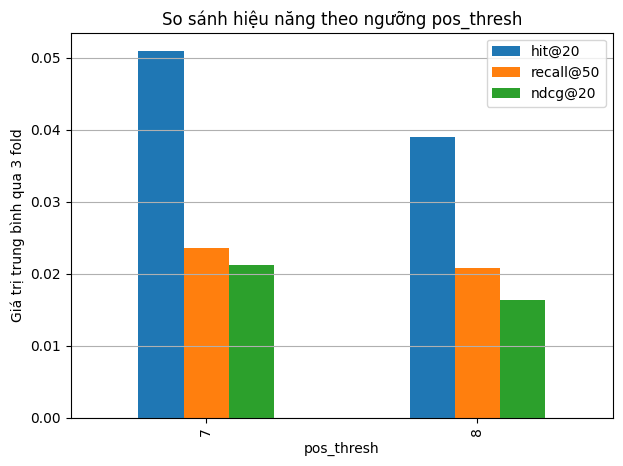

In [22]:
import matplotlib.pyplot as plt

summary = cb_results_df.groupby('pos_thresh')[['hit@20','recall@50','ndcg@20']].mean().round(4)
summary.plot(kind='bar', figsize=(7,5))
plt.title('So sánh hiệu năng theo ngưỡng pos_thresh')
plt.ylabel('Giá trị trung bình qua 3 fold')
plt.grid(axis='y')
plt.show()

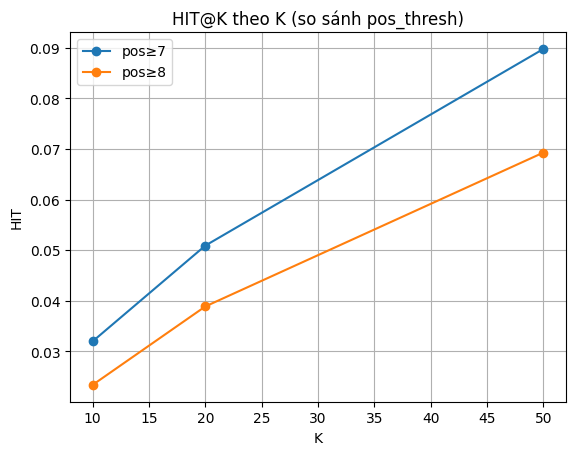

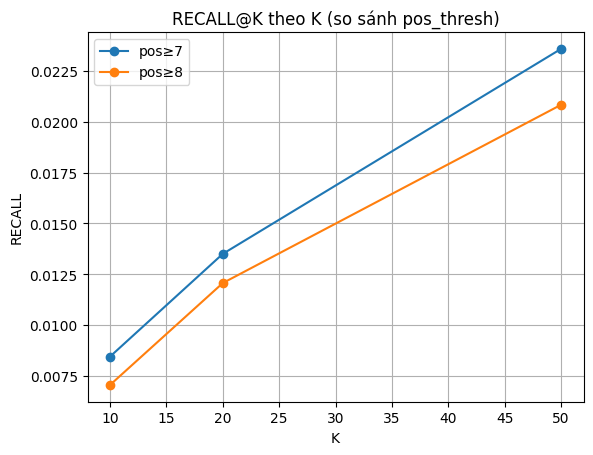

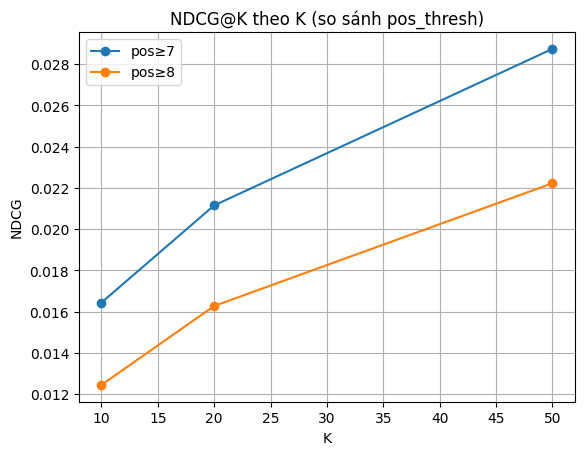

In [21]:
for metric in ['hit','recall','ndcg']:
    plt.figure()
    for pos in sorted(cb_results_df['pos_thresh'].unique()):
        vals = [cb_results_df[cb_results_df['pos_thresh']==pos][f'{metric}@{K}'].mean()
                for K in (10,20,50)]
        plt.plot([10,20,50], vals, marker='o', label=f'pos≥{pos}')
    plt.title(f'{metric.upper()}@K theo K (so sánh pos_thresh)')
    plt.xlabel('K'); plt.ylabel(metric.upper())
    plt.legend(); plt.grid(True)
    plt.show()

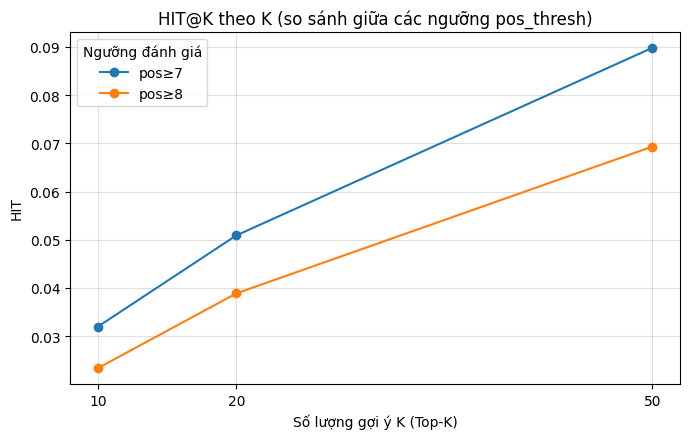

Đã lưu: figs/line_hit_vs_K.png


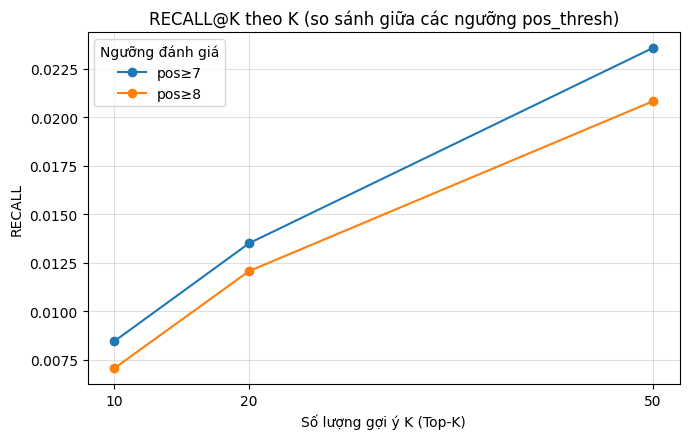

Đã lưu: figs/line_recall_vs_K.png


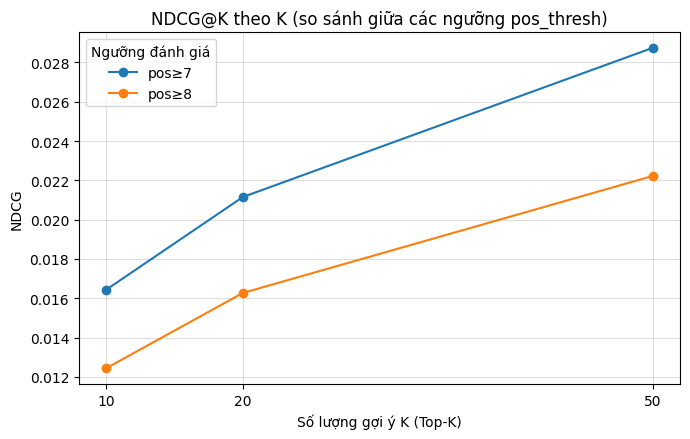

Đã lưu: figs/line_ndcg_vs_K.png


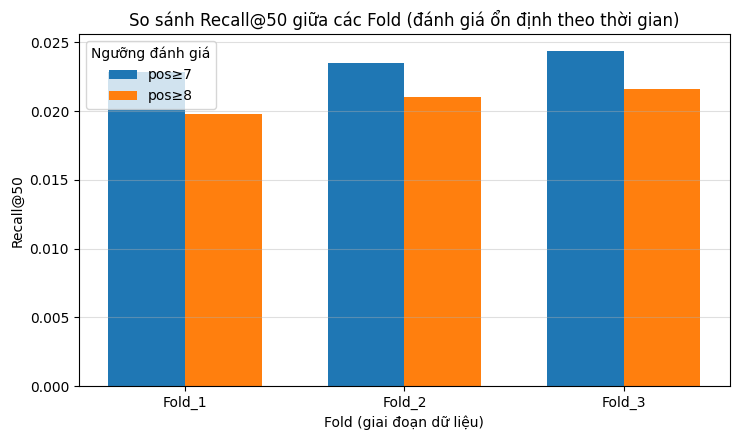

Đã lưu: figs/bar_fold_recall50.png


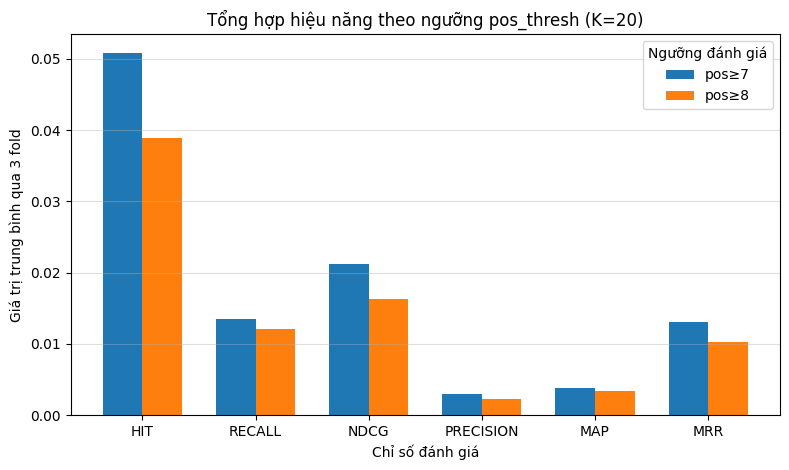

Đã lưu: figs/bar_pos_thresh_K20.png


In [24]:
# ================== VẼ 3 BIỂU ĐỒ TỔNG KẾT CHO CONTENT-BASED ==================
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# ====== kiểm tra ======
assert 'cb_results_df' in globals(), "Chưa có cb_results_df. Hãy chạy phần Runner trước."

# ====== hàm phụ ======
def _mean(df, col): 
    return float(df[col].mean()) if col in df.columns and not df[col].isna().all() else np.nan

# ====== thư mục lưu hình ======
os.makedirs("figs", exist_ok=True)

# ============================================================
# 1️⃣ LINE CHART — Các chỉ số theo K (Hit, Recall, nDCG)
# ============================================================
Ks = (10, 20, 50)
metrics = ['hit', 'recall', 'ndcg']

for metric in metrics:
    plt.figure(figsize=(7,4.5))
    for pos in sorted(cb_results_df['pos_thresh'].unique()):
        vals = [cb_results_df[cb_results_df['pos_thresh']==pos][f'{metric}@{K}'].mean() for K in Ks]
        plt.plot(Ks, vals, marker='o', label=f'pos≥{pos}')
    plt.title(f'{metric.upper()}@K theo K (so sánh giữa các ngưỡng pos_thresh)')
    plt.xlabel('Số lượng gợi ý K (Top-K)')
    plt.ylabel(metric.upper())
    plt.xticks(Ks)
    plt.grid(True, alpha=0.4)
    plt.legend(title='Ngưỡng đánh giá')
    plt.tight_layout()
    outpath = f'figs/line_{metric}_vs_K.png'
    plt.savefig(outpath, dpi=200)
    plt.show()
    print(f"Đã lưu: {outpath}")

# ============================================================
# 2️⃣ GROUPED BAR — So sánh Recall@50 giữa các Fold
# ============================================================
folds_order = sorted(cb_results_df['fold'].unique())
pos_vals = sorted(cb_results_df['pos_thresh'].unique())
bar_width = 0.35
x = np.arange(len(folds_order))

plt.figure(figsize=(7.5,4.5))
for i, pos in enumerate(pos_vals):
    vals = []
    for f in folds_order:
        sub = cb_results_df[(cb_results_df['fold']==f) & (cb_results_df['pos_thresh']==pos)]
        vals.append(_mean(sub, 'recall@50'))
    plt.bar(x + (i-0.5)*bar_width, vals, width=bar_width, label=f'pos≥{pos}')
plt.title('So sánh Recall@50 giữa các Fold (đánh giá ổn định theo thời gian)')
plt.xlabel('Fold (giai đoạn dữ liệu)')
plt.ylabel('Recall@50')
plt.xticks(x, folds_order)
plt.grid(axis='y', alpha=0.4)
plt.legend(title='Ngưỡng đánh giá')
plt.tight_layout()
outpath = 'figs/bar_fold_recall50.png'
plt.savefig(outpath, dpi=200)
plt.show()
print(f"Đã lưu: {outpath}")

# ============================================================
# 3️⃣ BAR CHART — Tổng hợp chỉ số giữa các ngưỡng pos_thresh
# ============================================================
K = 20  # chọn K=20 để đại diện
metrics2 = ['hit', 'recall', 'ndcg', 'precision', 'map', 'mrr']
agg = (cb_results_df
       .groupby('pos_thresh')[[f'{m}@{K}' for m in metrics2]]
       .mean()
       .reindex(pos_vals))

plt.figure(figsize=(8,4.8))
x = np.arange(len(metrics2))
width = 0.35
for i, pos in enumerate(agg.index):
    vals = [agg.loc[pos, f'{m}@{K}'] for m in metrics2]
    plt.bar(x + (i-0.5)*width, vals, width=width, label=f'pos≥{pos}')
plt.title(f'Tổng hợp hiệu năng theo ngưỡng pos_thresh (K={K})')
plt.xlabel('Chỉ số đánh giá')
plt.ylabel('Giá trị trung bình qua 3 fold')
plt.xticks(x, [m.upper() for m in metrics2])
plt.grid(axis='y', alpha=0.4)
plt.legend(title='Ngưỡng đánh giá')
plt.tight_layout()
outpath = f'figs/bar_pos_thresh_K{K}.png'
plt.savefig(outpath, dpi=200)
plt.show()
print(f"Đã lưu: {outpath}")

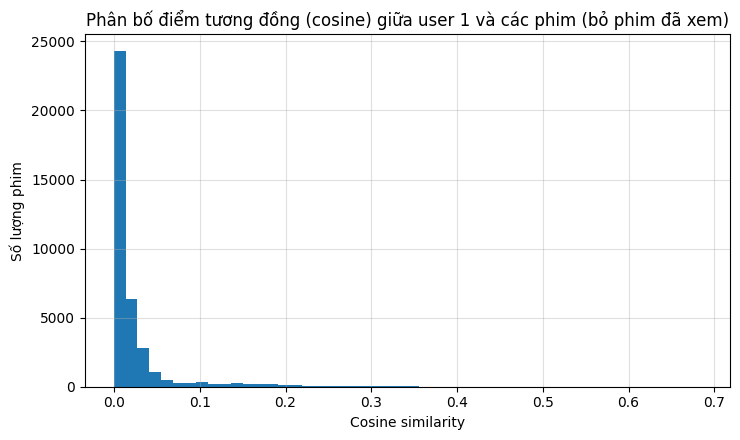

Saved: figs_realistic/01_hist_cosine.png


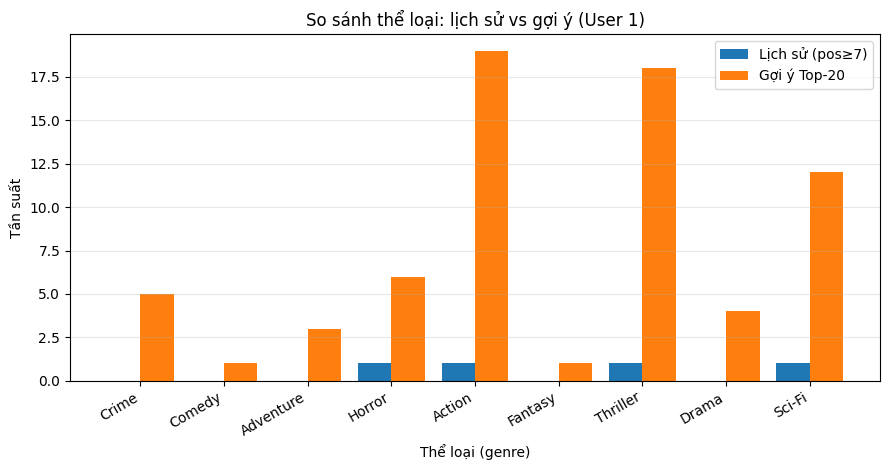

Saved: figs_realistic/02_genre_history_vs_rec.png


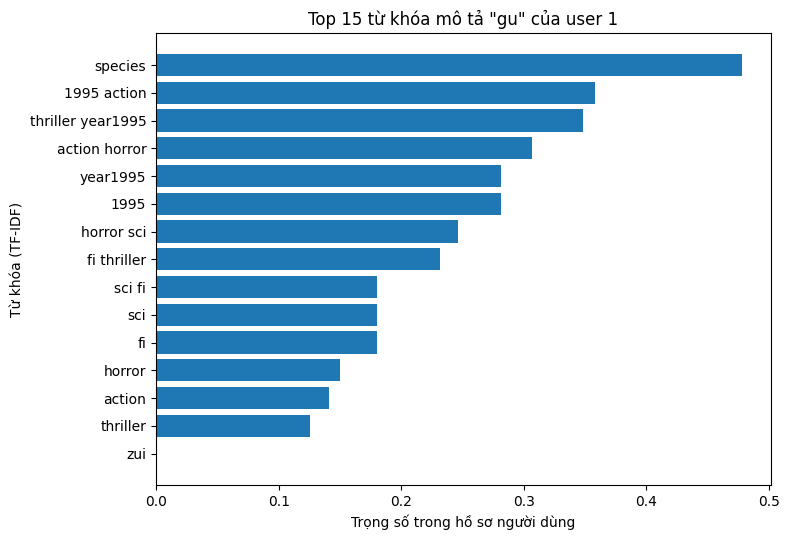

Saved: figs_realistic/03_user_profile_top_terms.png


In [26]:
# ================== REAL-WORLD PLOTS FOR DEFENSE ==================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- safety checks
assert 'profiles_demo' in globals() and len(profiles_demo)>0, "Chưa có profiles_demo (hãy chạy cell F trước)."
assert '_vectorizer' in globals(), "Thiếu _vectorizer (fit_item_vectorizer)."
assert 'X_items' in globals() and 'movie_ids' in globals() and 'id2row' in globals(), "Thiếu ma trận item."
assert 'data' in globals(), "Thiếu DataFrame data."
assert 'seen_demo' in globals(), "Thiếu seen_demo."

# ---- pick a demo user (re-use uid_demo if set)
try:
    uid_demo
except NameError:
    uid_demo = next(iter(profiles_demo.keys()))

uvec = profiles_demo[uid_demo]
os.makedirs("figs_realistic", exist_ok=True)

# ---------------- 1) HISTOGRAM COSINE (user vs all movies) ----------------
scores_all = (uvec @ X_items.T).toarray().ravel()

# Ẩn phim đã xem trong train (nếu muốn xem “không khí” recommendation thuần)
mask_seen = np.fromiter((m in seen_demo.get(uid_demo, set()) for m in movie_ids), bool, movie_ids.size)
scores_for_hist = scores_all.copy()
scores_for_hist[mask_seen] = np.nan
vals = scores_for_hist[~np.isnan(scores_for_hist)]

plt.figure(figsize=(7.5,4.5))
plt.hist(vals, bins=50)
plt.title(f'Phân bố điểm tương đồng (cosine) giữa user {uid_demo} và các phim (bỏ phim đã xem)')
plt.xlabel('Cosine similarity'); plt.ylabel('Số lượng phim')
plt.grid(True, alpha=0.4)
plt.tight_layout()
out1 = "figs_realistic/01_hist_cosine.png"
plt.savefig(out1, dpi=200); plt.show()
print("Saved:", out1)

# ---------------- helpers cho GENRE ----------------
def _ensure_genre_list(s):
    """Trả list genre từ cột GenresList hoặc Genres (fallback)."""
    if isinstance(s, (list, tuple, np.ndarray)):
        return list(s)
    if isinstance(s, str):
        # Thử tách dạng pipe "Action|Sci-Fi"
        if '|' in s:
            return [g.strip() for g in s.split('|') if g.strip()]
        # Trường hợp chuỗi như "['Action' 'Sci-Fi']" -> thay ' ' giữa token bằng dấu phẩy
        if s.startswith('[') and s.endswith(']'):
            s2 = s.strip('[]').replace("'", "").replace('"', '').strip()
            parts = [p.strip() for p in s2.replace('  ', ' ').split() if p.strip()]
            return parts
    return []

def _flatten_genres(df_movies):
    if 'GenresList' in df_movies.columns:
        return df_movies['GenresList'].apply(_ensure_genre_list)
    elif 'Genres' in df_movies.columns:
        return df_movies['Genres'].apply(_ensure_genre_list)
    else:
        return pd.Series([[] for _ in range(len(df_movies))], index=df_movies.index)

# ---------------- 2) GENRE: history vs recommendations ----------------
# Lấy lịch sử "thích" (pos >= 7) của user trong TRAIN
hist_df = train_demo[(train_demo['UserID']==uid_demo) & (train_demo['Rating']>=7)]
hist_movies = data.merge(hist_df[['MovieID']].drop_duplicates(), on='MovieID', how='inner').drop_duplicates('MovieID')
hist_genres_series = _flatten_genres(hist_movies)
hist_genres = pd.Series([g for lst in hist_genres_series for g in lst if g]).value_counts()

# Lấy top-K recs
K_view = 20
recs_demo = recommend_for_users({uid_demo: uvec}, X_items, movie_ids, seen_demo, K=K_view).get(uid_demo, [])
rec_ids = [mid for mid, _ in recs_demo]
rec_movies = data[data['MovieID'].isin(rec_ids)].drop_duplicates('MovieID')
rec_genres_series = _flatten_genres(rec_movies)
rec_genres = pd.Series([g for lst in rec_genres_series for g in lst if g]).value_counts()

# Gộp top 10 genre cho dễ nhìn
genres_union = list(set(hist_genres.head(10).index).union(set(rec_genres.head(10).index)))
hist_vals = [hist_genres.get(g, 0) for g in genres_union]
rec_vals  = [rec_genres.get(g, 0)  for g in genres_union]

x = np.arange(len(genres_union)); width = 0.4
plt.figure(figsize=(9,4.8))
plt.bar(x - width/2, hist_vals, width, label='Lịch sử (pos≥7)')
plt.bar(x + width/2, rec_vals,  width, label=f'Gợi ý Top-{K_view}')
plt.xticks(x, genres_union, rotation=30, ha='right')
plt.ylabel('Tần suất'); plt.xlabel('Thể loại (genre)')
plt.title(f'So sánh thể loại: lịch sử vs gợi ý (User {uid_demo})')
plt.legend(); plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
out2 = "figs_realistic/02_genre_history_vs_rec.png"
plt.savefig(out2, dpi=200); plt.show()
print("Saved:", out2)

# ---------------- 3) TOP TERMS từ profile user (TF-IDF) ----------------
vocab = _vectorizer.get_feature_names_out()
uarr = uvec.toarray().ravel()
top_n = 15
top_idx = np.argsort(uarr)[-top_n:][::-1]
top_terms = [vocab[i] for i in top_idx]
top_vals  = uarr[top_idx]

plt.figure(figsize=(8,5.5))
plt.barh(range(top_n), top_vals[::-1])
plt.yticks(range(top_n), top_terms[::-1])
plt.xlabel('Trọng số trong hồ sơ người dùng'); plt.ylabel('Từ khóa (TF-IDF)')
plt.title(f'Top {top_n} từ khóa mô tả "gu" của user {uid_demo}')
plt.tight_layout()
out3 = "figs_realistic/03_user_profile_top_terms.png"
plt.savefig(out3, dpi=200); plt.show()
print("Saved:", out3)

4️⃣ Nếu hội đồng hỏi “tại sao điểm cosine lại nhỏ như vậy?”

“Vì dữ liệu phim rất đa dạng, còn mỗi người chỉ thích một vài thể loại nhất định.
TF-IDF vector rất thưa và chuẩn hóa, nên chỉ vài phim có nội dung thật sự gần gu người dùng mới đạt điểm cao (0.4–0.6).
Phần còn lại hầu hết là không liên quan nên có cosine ~0.”

1️⃣ Các cột Action, Fantasy, Sci-Fi, Thriller cao nhất → đây là các core genres mà hệ thống nhận diện rõ trong hồ sơ user → đúng “gu”.

2️⃣ Các cột Drama, Comedy, Crime cũng cao vì:

Nhiều phim trong IMDb có nhiều tag cùng lúc, ví dụ:

“Men in Black (1997)” → Action | Comedy | Sci-Fi

“Inception (2010)” → Action | Drama | Sci-Fi | Thriller

TF-IDF coi mỗi thể loại là token độc lập, nên các phim có “Action + Drama” đều làm tăng trọng số Drama luôn.
→ Thực ra mô hình không nghĩ rằng user thích “Drama” độc lập, mà nó chỉ thấy Drama thường xuất hiện cùng với các thể loại người dùng thích.

“Ở biểu đồ này, ta thấy các thể loại chính như Action, Sci-Fi, Thriller chiếm ưu thế rõ rệt, phản ánh đúng gu người dùng.
Một vài thể loại phụ như Drama hay Comedy xuất hiện vì các phim hành động hoặc viễn tưởng thường được gắn kèm các tag này trên IMDb.
Đây là đặc trưng của dữ liệu, chứ không phải lỗi mô hình.”

Biểu đồ ngang thể hiện những từ khóa có trọng số cao nhất trong profile của user (từ vector TF-IDF).

Các từ như action, sci-fi, thriller, 1995, species… phản ánh rõ nội dung phim mà user từng thích.